<a href="https://colab.research.google.com/github/2203A51389/AIML-BATCH-19-20/blob/main/mail_spam_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'email-spam-classification-dataset-csv:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F547699%2F998616%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240501%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240501T100754Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D52872e15035f0ae71c7164e772fd2fbf820a50d68900a7517d0c3005076cd22b2f6fa54cf861a1b5482b2704fd5e1aa7b69293ceb4cdec2d90f658aa543634e411158866e0436312517abb9015a76d90b4643e1a05c9794f494f51a2f2760b0f33db42aa7b0fc26369be44963a42b130901d33fd0ba5873866711e4a28e57d8b476c495ac71565ede44443b16682382d22079fdca8b2fc86e90246dfd67de487d6a9733b4f0a91ff6519d28994b8d877fb3cf6a6a952adeb35a3d97d16eb56674ae438f025e7dfc63006f70b5f8f4e1c0001092882a648aa2ee18d4b472192708e4091845c4a9b05f16d7081b52300143a206844db5bff2a3b92e337989b70c4,email-spam-classification-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3962399%2F6897944%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240501%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240501T100754Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D91eacb61428fdf0ee6cb7469a80e41792fb9c7846532eb875bf238ee10762d758c4d336901290b3edcc833bf2ed8d6f824753d32f189b4793d2d563b82fb86eb39094e7c6ca9aa83498695df6642c266af5476744c2c55118a00ce8e6181c0657da56c097244b47e57b59106416a21ac9cb5f4f52883e04e3890f2bba2c504547d16a025f70de54fd308ef21b00590d76a2756812bc90572843784af97f0b74006b3a340782c19744e6e148b96e0e6d9dec3d33e61d8428f636d1dee5e9ff031e2ea561f2ce6b48327485204e513788bf05a2f03c6c91813fbffa2cf734e97f4ff3f9acc034208e1cdb7a630eadab0afe1e198ef7a21656e88f59e76dda52779'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1738291 bytes downloaded
Downloaded and uncompressed: email-spam-classification-dataset-csv
[==================================================] 45062184 bytes downloaded
Downloaded and uncompressed: email-spam-classification-dataset
Data source import complete.


In [3]:
import numpy as np
import pandas as pd

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [6]:
df = pd.read_csv("/kaggle/input/email-spam-classification-dataset-csv/emails.csv")

In [7]:
df.head()

,Email No.,the,to,ect,and,for,of,a,you,hou,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
0,Email 1,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Email 2,8,13,24,6,6,2,102,1,27,...,0,0,0,0,0,0,0,1,0,0
2,Email 3,0,0,1,0,0,0,8,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Email 4,0,5,22,0,5,1,51,2,10,...,0,0,0,0,0,0,0,0,0,0
4,Email 5,7,6,17,1,5,2,57,0,9,...,0,0,0,0,0,0,0,1,0,0


In [8]:
df.tail()

,Email No.,the,to,ect,and,for,of,a,you,hou,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
5167,Email 5168,2,2,2,3,0,0,32,0,0,...,0,0,0,0,0,0,0,0,0,0
5168,Email 5169,35,27,11,2,6,5,151,4,3,...,0,0,0,0,0,0,0,1,0,0
5169,Email 5170,0,0,1,1,0,0,11,0,0,...,0,0,0,0,0,0,0,0,0,1
5170,Email 5171,2,7,1,0,2,1,28,2,0,...,0,0,0,0,0,0,0,1,0,1
5171,Email 5172,22,24,5,1,6,5,148,8,2,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5172 entries, 0 to 5171
Columns: 3002 entries, Email No. to Prediction
dtypes: int64(3001), object(1)
memory usage: 118.5+ MB


In [10]:
df.isnull().sum()

Email No.     0
the           0
to            0
ect           0
and           0
             ..
military      0
allowing      0
ff            0
dry           0
Prediction    0
Length: 3002, dtype: int64

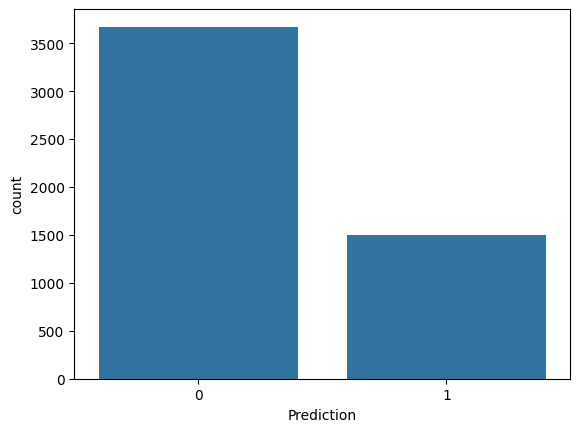

In [11]:
sns.countplot(data = df, x = "Prediction")
plt.show()

In [12]:
df = df.iloc[:, 1:]
df

,the,to,ect,and,for,of,a,you,hou,in,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
0,0,0,1,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,13,24,6,6,2,102,1,27,18,...,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,8,0,0,4,...,0,0,0,0,0,0,0,0,0,0
3,0,5,22,0,5,1,51,2,10,1,...,0,0,0,0,0,0,0,0,0,0
4,7,6,17,1,5,2,57,0,9,3,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5167,2,2,2,3,0,0,32,0,0,5,...,0,0,0,0,0,0,0,0,0,0
5168,35,27,11,2,6,5,151,4,3,23,...,0,0,0,0,0,0,0,1,0,0
5169,0,0,1,1,0,0,11,0,0,1,...,0,0,0,0,0,0,0,0,0,1
5170,2,7,1,0,2,1,28,2,0,8,...,0,0,0,0,0,0,0,1,0,1


In [13]:
X = df.iloc[:, :3000]
X

,the,to,ect,and,for,of,a,you,hou,in,...,enhancements,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry
0,0,0,1,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,13,24,6,6,2,102,1,27,18,...,0,0,0,0,0,0,0,0,1,0
2,0,0,1,0,0,0,8,0,0,4,...,0,0,0,0,0,0,0,0,0,0
3,0,5,22,0,5,1,51,2,10,1,...,0,0,0,0,0,0,0,0,0,0
4,7,6,17,1,5,2,57,0,9,3,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5167,2,2,2,3,0,0,32,0,0,5,...,0,0,0,0,0,0,0,0,0,0
5168,35,27,11,2,6,5,151,4,3,23,...,0,0,0,0,0,0,0,0,1,0
5169,0,0,1,1,0,0,11,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5170,2,7,1,0,2,1,28,2,0,8,...,0,0,0,0,0,0,0,0,1,0


In [14]:
y = df.iloc[:, -1]
y

0       0
1       0
2       0
3       0
4       0
       ..
5167    0
5168    0
5169    1
5170    1
5171    0
Name: Prediction, Length: 5172, dtype: int64

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

In [ ]:
def perform(y_pred):
    print("Precision : ", precision_score(y_test, y_pred))
    print("Recall : ", recall_score(y_test, y_pred))
    print("Accuracy : ", accuracy_score(y_test, y_pred))
    print("F1 Score : ", f1_score(y_test, y_pred))
    print('')
    print(confusion_matrix(y_test, y_pred), '\n')
    cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred))
    cm.plot()

In [16]:
model_LR = LogisticRegression()
model_LR.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [18]:
print(classification_report(y_test, y_pred_LR))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1080
           1       0.94      0.94      0.94       472

    accuracy                           0.96      1552
   macro avg       0.96      0.96      0.96      1552
weighted avg       0.96      0.96      0.96      1552



In [19]:
model_XGB = XGBClassifier()
model_XGB.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [34]:
y_pred_XGB = model_XGB.predict(X_test)
print(y_pred_XGB)

[0 1 0 ... 0 1 0]


In [32]:
print(classification_report(y_test, y_pred_XGB))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1080
           1       0.96      0.97      0.97       472

    accuracy                           0.98      1552
   macro avg       0.97      0.98      0.98      1552
weighted avg       0.98      0.98      0.98      1552



In [21]:
model_SVC = SVC()
model_SVC.fit(X_train, y_train)

SVC()

In [24]:
y_pred_SVC = model_SVC.predict(X_test)
print(y_pred_SVC)

[0 0 0 ... 0 1 0]


In [26]:
print(classification_report(y_test, y_pred_SVC))

              precision    recall  f1-score   support

           0       0.78      0.98      0.87      1080
           1       0.88      0.36      0.51       472

    accuracy                           0.79      1552
   macro avg       0.83      0.67      0.69      1552
weighted avg       0.81      0.79      0.76      1552



In [27]:
model_NB = GaussianNB()
model_NB.fit(X_train, y_train)

GaussianNB()

In [31]:
y_pred_NB = model_NB.predict(X_test)
print(classification_report(y_test, y_pred_NB))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1080
           1       0.89      0.96      0.92       472

    accuracy                           0.95      1552
   macro avg       0.94      0.95      0.94      1552
weighted avg       0.95      0.95      0.95      1552

